<a href="https://colab.research.google.com/github/thaarres/fastML_graphics/blob/main/latency_throughput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install mplhep

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep

In [135]:
sheet_url = (
    "https://docs.google.com/spreadsheets/d/"
    "1sG9q4gRvuYhntJKcbKlxJx_koTWvsMKISdNAG4uLCHA/"
    "export?format=csv&gid=0"
)
df = pd.read_csv(sheet_url)

print("Columns found:", df.columns.tolist())
print(df.head())

df = df.drop([5, 6, 12]) #Drop FCC-hh split vertex/calo and total internet

services = df["Service"].to_numpy()
latency = df["Latency (s)"].to_numpy()
throughput = df["Throughput (Tbps)"].to_numpy()
unit_size_mb = df["Unit size (MB)"].to_numpy()

# Convert unit size from MB to GB:
# unit_size = unit_size_mb / 1024

unit_size = unit_size_mb  # units: MB

Columns found: ['Service', 'Latency (s)', 'Throughput (Tbps)', 'Unit size (MB)', 'Notes:']
            Service   Latency (s)  Throughput (Tbps)  Unit size (MB)  \
0           Netflix  5.000000e+00           139.2248        1000.000   
1  HL-LHC front-end  9.000000e-07          2370.0000           7.400   
2   HL-LHC back-end  1.250000e-05            64.0000           0.200   
3        HL-LHC HLT  1.000000e+00            44.4000           7.400   
4  FCC-ee front-end  7.200000e-07            93.6000           0.234   

                                              Notes:  
0      #Multiply fraction by total internet bandwith  
1  #assuming 36-BX (HGCAL) buffer on ASIC (event ...  
2                                   #200kB size, TDR  
3  #size from https://cds.cern.ch/record/2712248/...  
4  # assuming 36BX at 50 MHz, event size from htt...  


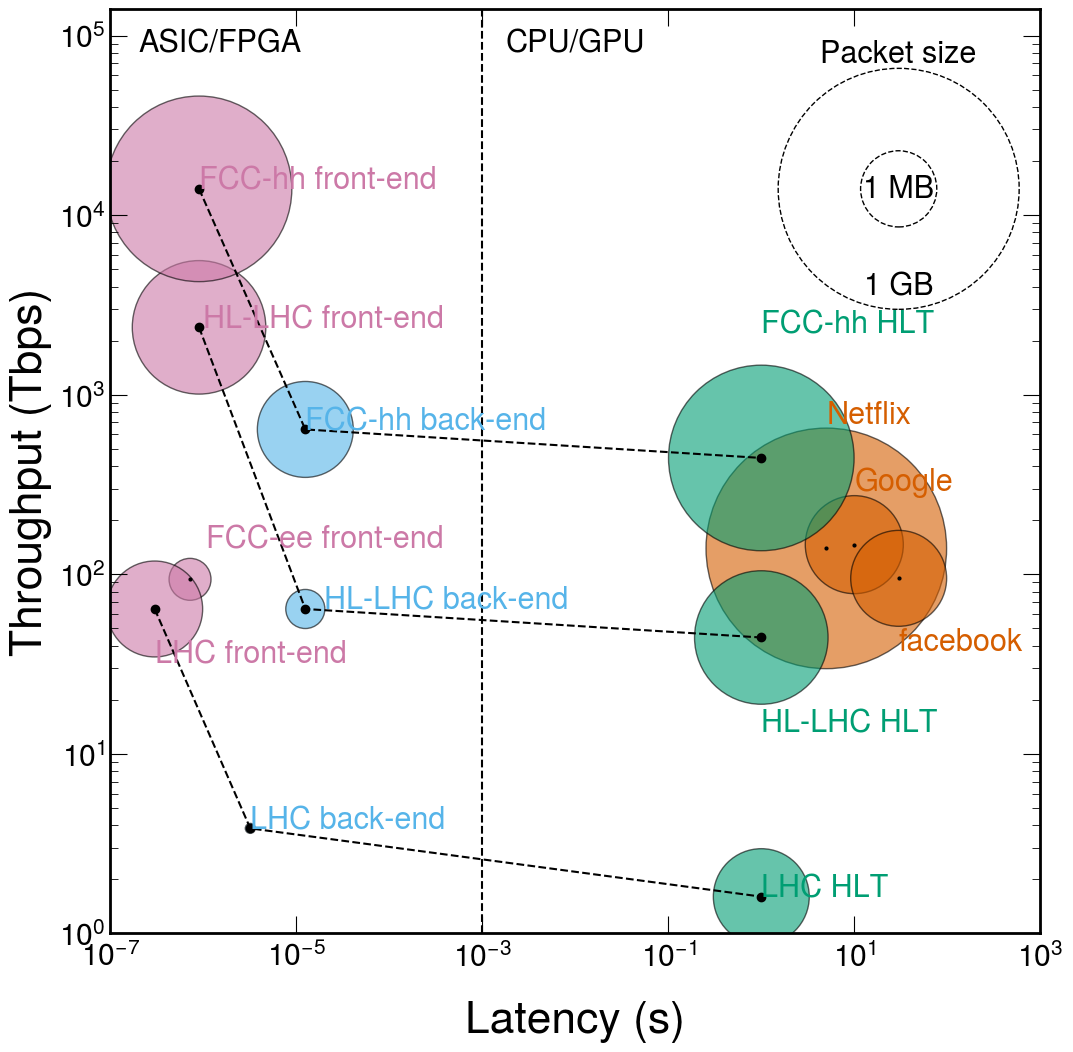

In [138]:
base_colors = [
    '#44AA99', '#56B4E9', '#009E73', '#F0E442',
    '#0072B2', '#D55E00', '#999999', '#CC79A7',
    '#882255', '#E69F00', '#DD4477', '#117733'
]
colors = base_colors * ((len(services) // len(base_colors)) + 1)

plt.style.use(mplhep.style.CMS)
plt.figure(figsize=(12, 12))

# Prevent issues with zeros
unit_size_safe = np.maximum(unit_size, 1e-6)

# Plot log(area) for better visual
marker_area = np.log10(unit_size_safe + 1) * 1e4  # scaling factor for visibility

# Make some reference sizes for log area
area_1MB = np.log10(1 + 1) * 1e4      # log10(2) * 1e4
area_1GB = np.log10(1024 + 1) * 1e4   # log10(1025) * 1e4
# Coordinates for the legend circles
x0, y0 = max(latency), max(throughput)  # top-left
x_offsets = [0, 0]
y_offsets = [0, 0]

plt.scatter([x0 + x for x in x_offsets],
            [y0 + y for y in y_offsets],
            s=[area_1MB, area_1GB],
            facecolors='none', edgecolors='black',linestyle='--')

plt.text(x0 , y0, '1 MB', va='center',ha='center', fontsize=22)
plt.text(x0 , y0-1e4, '1 GB', va='center',ha='center', fontsize=22)

plt.text(x0, y0+6.5e4, 'Packet size', fontsize=22,
         verticalalignment='center', horizontalalignment='center')

color_array = [
    "#D55E00",  # index 0 → remaining
    "#CC79A7",  # index 1 → group1 (purple/pink)
    "#56B4E9",  # index 2 → group2 (blue)
    "#009E73",  # index 3 → group3 (green)
    "#CC79A7",  # index 4 → group1
    "#CC79A7",  # index 5 → group1
    "#56B4E9",  # index 6 → group2
    "#CC79A7",  # index 7 → group1
    "#56B4E9",  # index 8 → group2
    "#009E73",  # index 9 → group3
    "#D55E00",  # index 10 → remaining
    "#D55E00",   # index 11 → remaining
    "#009E73",  # index 3
]


plt.scatter(latency, throughput, s=marker_area, alpha=0.6,
            c=color_array[:len(services)], edgecolors='black')
plt.scatter(latency, throughput, s=4, c='black', alpha=1)  # black center dot


# Add labels next to each point, manually displace to avoid overlap
vertical  = [5.,1. ,1. ,0.3,1.5,1.,1.,0.5,1.,1.,2.0,0.4,5.]
horizontal= [1.,1.1,1.6,1.,1.5,1.,1.,1. ,1.,1., 1.,1.,1.]



for i, service in enumerate(services):
    plt.text(latency[i] * horizontal[i], throughput[i] * vertical[i],
             service, fontsize=22,c=color_array[i])

plt.xlim(1e-7, 1e3)
plt.ylim(1, np.max(throughput) * 10)

# hardware/software line at latency = 1e-3
plt.axvline(1e-3, color='black', linestyle='--')

# # Highlight regions if neccessary
# plt.fill_betweenx([1, 1e6], 1e-8, 1e-3, color='lightgreen', alpha=0.2)
# plt.fill_betweenx([1, 1e6], 1e-3, np.max(latency) * 1000, color='lightcoral', alpha=0.2)

# Region names
plt.text(1.5e-6, 0.9e5, 'ASIC/FPGA', fontsize=22,
         verticalalignment='center', horizontalalignment='center')
plt.text(1e-2, 0.9e5, 'CPU/GPU', fontsize=22,
         verticalalignment='center', horizontalalignment='center')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Latency (s)', fontsize=32, ha='center', labelpad=20)
plt.ylabel('Throughput (Tbps)', fontsize=32, va='center', ha='center', labelpad=20)

#connect by frontend/backend/HLT
# x_points = [latency[5], latency[1], latency[4], latency[7]]
# y_points = [throughput[5], throughput[1], throughput[4], throughput[7]]
# plt.plot(x_points, y_points, linestyle='--', color='black', marker='o')


# x_points = [latency[6], latency[2], latency[8]]
# y_points = [throughput[6], throughput[2], throughput[8]]
# plt.plot(x_points, y_points, linestyle='--', color='black', marker='o')

# x_points = [latency[3], latency[9]]
# y_points = [throughput[3], throughput[9]]
# plt.plot(x_points, y_points, linestyle='--', color='black', marker='o')

#connect by project
x_points = [latency[1], latency[2], latency[3]]
y_points = [throughput[1], throughput[2], throughput[3]]
plt.plot(x_points, y_points, linestyle='--', color='black', marker='o')


x_points = [latency[5], latency[6], latency[12]]
y_points = [throughput[5], throughput[6],throughput[12]]
plt.plot(x_points, y_points, linestyle='--', color='black', marker='o')

x_points = [latency[7],latency[8], latency[9]]
y_points = [throughput[7],throughput[8], throughput[9]]
plt.plot(x_points, y_points, linestyle='--', color='black', marker='o')


# plt.tight_layout()

plt.savefig("throughput_latency.pdf", bbox_inches='tight')
plt.savefig("throughput_latency.png", dpi=300, bbox_inches='tight')

plt.show()